In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMZN_2021.csv')

In [3]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'amzn', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,0.0,0.0,0.000000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,1.0,0.0,1.0,0.000000,0,1.0,0.5,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,1.0,0.0,1.0,0.000000,0,2.0,1.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,2.0,1.0,3.0,33.332222,0,3.0,1.5,100.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.704330,0,-0.350508
4,2021-01-05,2.0,0.0,2.0,0.000000,0,4.0,2.0,100.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357044,1,-1.029896


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     319 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: AMZN Close Price

### Without Normalization

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '7D%Change', 'Volume', '2Dir', 'SD_log', 'Daily%Change', 'Dir', 'High', 'Low', '2D%Change', '7Dir', 'SD', 'Open', '3Dir', '4D%Change', '5D%Change', '5Dir', '6Dir', '6D%Change', '4Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,SD(t-1),Open(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Close(t-1)
7,3165.889893,2,3.0,2.0,5.0,39.999200,7.0,3.5,-72.727273,4.0,...,0.365688,3120.00000,0.0,-0.559200,-3.034943,0.0,0.0,-2.064871,0.0,3120.830078
9,3104.250000,4,3.0,5.0,8.0,62.499219,6.0,3.0,0.000000,5.0,...,0.297757,3167.52002,1.0,-1.735318,-1.097033,0.0,0.0,-0.347629,0.0,3127.469971
10,3120.760010,1,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,0.301481,3123.02002,0.0,-0.319823,-2.464887,0.0,0.0,-1.831340,0.0,3104.250000
11,3263.379883,2,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,0.345787,3107.00000,0.0,-0.002245,0.210328,1.0,0.0,-1.946145,0.0,3120.760010
12,3306.989990,3,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,1.053576,3181.98999,1.0,3.079387,4.567689,1.0,1.0,4.789976,1.0,3263.379883


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Open(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Close(t-1),Prediction
218,3525.149902,4,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,3513.000000,0.0,-1.321117,-0.129422,0.0,1.0,2.615248,0.0,3472.500000,3525.149902
219,3545.679932,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,3485.000000,0.0,1.036690,0.175048,1.0,1.0,1.384812,1.0,3525.149902,3545.679932
223,3676.570068,4,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,3566.350098,1.0,4.848309,6.438015,1.0,1.0,6.146092,1.0,3696.060059,3676.570068
226,3580.409912,2,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,3585.040039,0.0,0.874614,1.111082,1.0,1.0,0.969070,1.0,3580.040039,3580.409912
227,3504.560059,4,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,3562.669922,0.0,-3.129012,0.885036,1.0,1.0,1.121529,0.0,3580.409912,3504.560059


In [7]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(103, 100)
(32, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(96, 7, 100) (96,)
(25, 7, 100) (25,)
0.4623791344315302
0.4623791344315302


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMZN_Sentiment_ClosePrice_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.6394
Epoch 1: val_loss improved from inf to 0.14018, saving model to AMZN_Sentiment_ClosePrice_woNormalization.h5
6/6 [==============================] - 5s 449ms/step - loss: 0.6394 - val_loss: 0.1402
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0645
Epoch 2: val_loss improved from 0.14018 to 0.03227, saving model to AMZN_Sentiment_ClosePrice_woNormalization.h5
6/6 [==============================] - 1s 158ms/step - loss: 0.0645 - val_loss: 0.0323
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0348
Epoch 3: val_loss did not improve from 0.03227
6/6 [==============================] - 1s 181ms/step - loss: 0.0348 - val_loss: 0.0419
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0204
Epoch 4: val_loss did not improve from 0.03227
6/6 [==============================] - 1s 180ms/step - loss: 0.0204 - val_loss: 0.0333
Epoch 5/100
6/6 [=======================

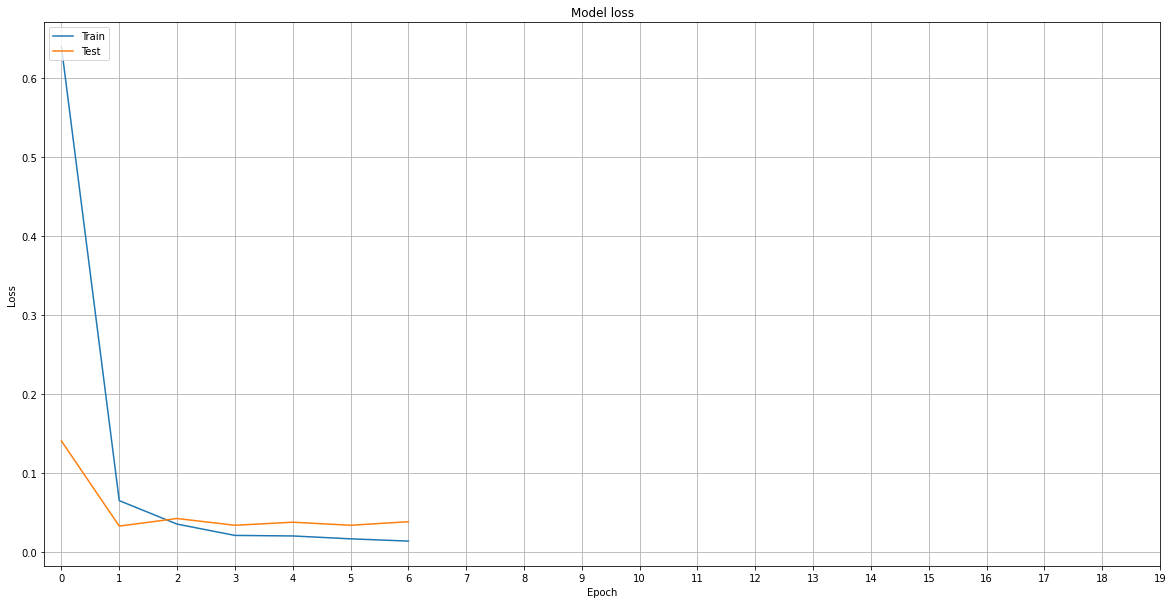

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 106.76
Mean Absolute Percentage Error (MAPE): 3.08 %
Median Absolute Percentage Error (MDAPE): 2.91 %


,MAE,MAPE,MDAPE
0,106.760332,3.075769,2.911102


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

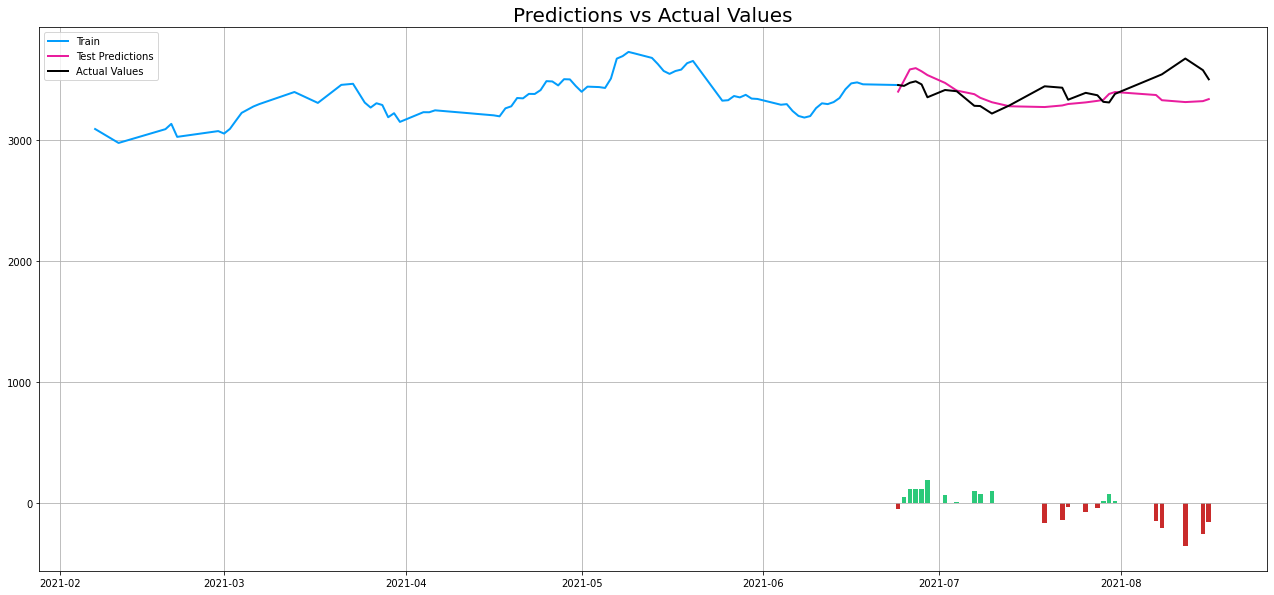

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '7D%Change', 'Volume', '2Dir', 'SD_log', 'Daily%Change', 'Dir', 'High', 'Low', '2D%Change', '7Dir', 'SD', 'Open', '3Dir', '4D%Change', '5D%Change', '5Dir', '6Dir', '6D%Change', '4Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,SD(t-1),Open(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Close(t-1)
7,3165.889893,2,3.0,2.0,5.0,39.999200,7.0,3.5,-72.727273,4.0,...,0.365688,3120.00000,0.0,-0.559200,-3.034943,0.0,0.0,-2.064871,0.0,3120.830078
9,3104.250000,4,3.0,5.0,8.0,62.499219,6.0,3.0,0.000000,5.0,...,0.297757,3167.52002,1.0,-1.735318,-1.097033,0.0,0.0,-0.347629,0.0,3127.469971
10,3120.760010,1,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,0.301481,3123.02002,0.0,-0.319823,-2.464887,0.0,0.0,-1.831340,0.0,3104.250000
11,3263.379883,2,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,0.345787,3107.00000,0.0,-0.002245,0.210328,1.0,0.0,-1.946145,0.0,3120.760010
12,3306.989990,3,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,1.053576,3181.98999,1.0,3.079387,4.567689,1.0,1.0,4.789976,1.0,3263.379883


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Open(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Close(t-1),Prediction
218,3525.149902,4,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,3513.000000,0.0,-1.321117,-0.129422,0.0,1.0,2.615248,0.0,3472.500000,3525.149902
219,3545.679932,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,3485.000000,0.0,1.036690,0.175048,1.0,1.0,1.384812,1.0,3525.149902,3545.679932
223,3676.570068,4,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,3566.350098,1.0,4.848309,6.438015,1.0,1.0,6.146092,1.0,3696.060059,3676.570068
226,3580.409912,2,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,3585.040039,0.0,0.874614,1.111082,1.0,1.0,0.969070,1.0,3580.040039,3580.409912
227,3504.560059,4,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,3562.669922,0.0,-3.129012,0.885036,1.0,1.0,1.121529,0.0,3580.409912,3504.560059


In [17]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(103, 100)
(32, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(96, 7, 100) (96,)
(25, 7, 100) (25,)
0.4623791344315302
0.4623791344315302


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMZN_Sentiment_ClosePrice_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.8665
Epoch 1: val_loss improved from inf to 0.14145, saving model to AMZN_Sentiment_ClosePrice_Normalized.h5
6/6 [==============================] - 4s 316ms/step - loss: 0.8665 - val_loss: 0.1414
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0574
Epoch 2: val_loss improved from 0.14145 to 0.03247, saving model to AMZN_Sentiment_ClosePrice_Normalized.h5
6/6 [==============================] - 1s 171ms/step - loss: 0.0574 - val_loss: 0.0325
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0521
Epoch 3: val_loss did not improve from 0.03247
6/6 [==============================] - 1s 163ms/step - loss: 0.0521 - val_loss: 0.0468
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0323
Epoch 4: val_loss improved from 0.03247 to 0.03246, saving model to AMZN_Sentiment_ClosePrice_Normalized.h5
6/6 [==============================] - 1s 193ms/step - loss: 0.0323 - val_lo

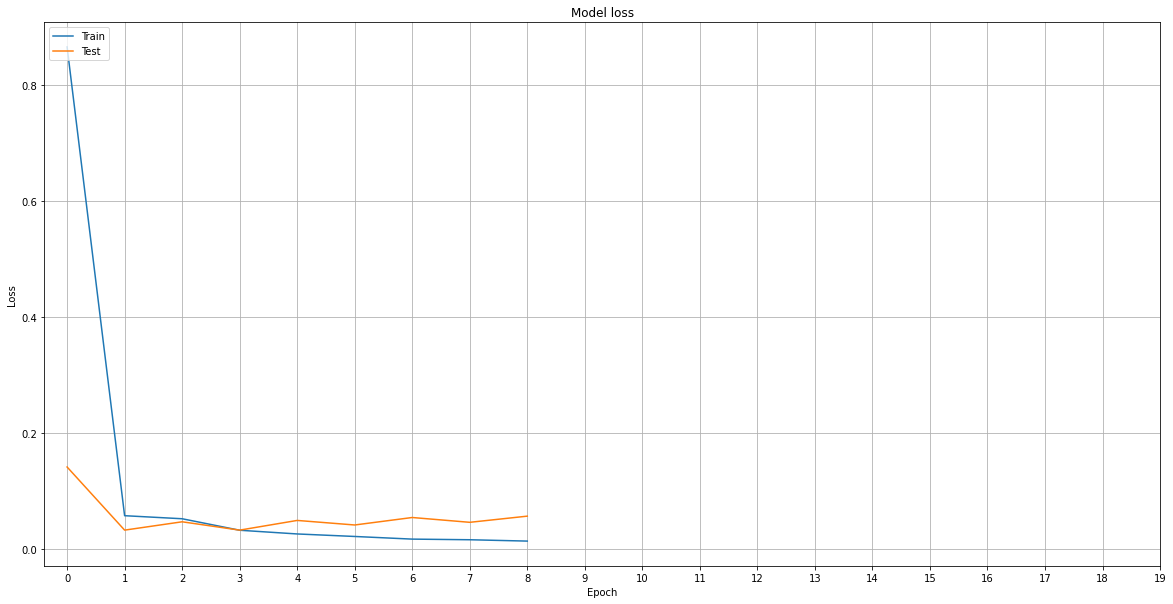

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 100.39
Mean Absolute Percentage Error (MAPE): 2.89 %
Median Absolute Percentage Error (MDAPE): 2.71 %


,MAE,MAPE,MDAPE
0,100.389561,2.890288,2.711095


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

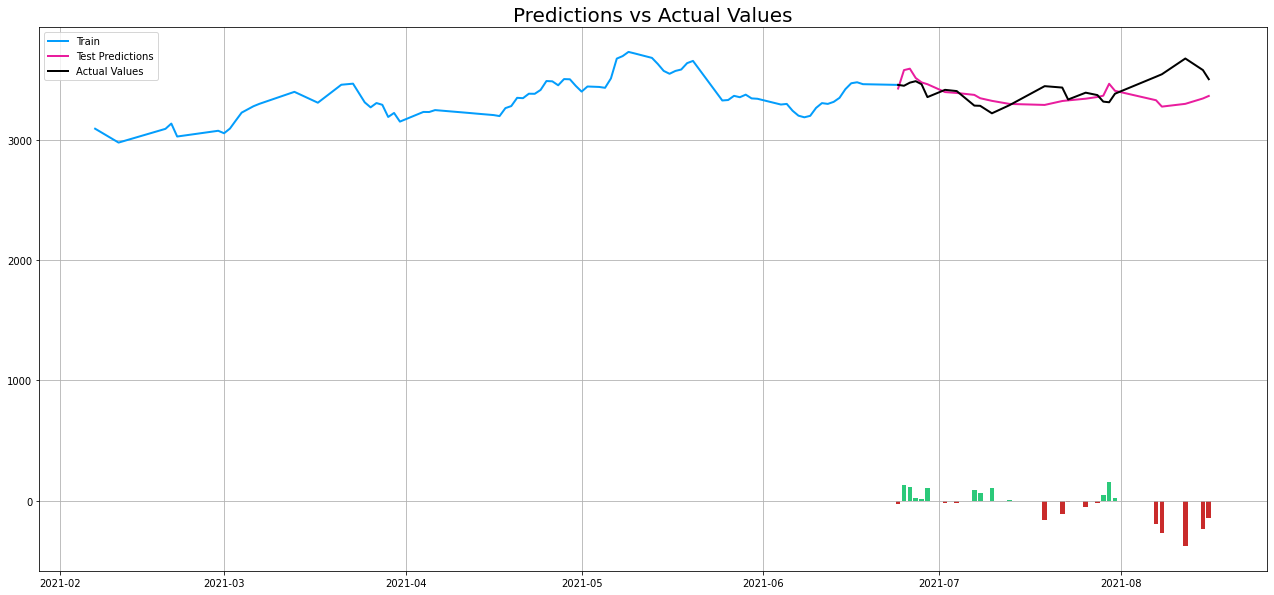

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: AMZN Daily%Change

### Without Normalization

In [25]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '7D%Change', 'Volume', '2Dir', 'SD_log', 'Dir', 'High', 'Low', '2D%Change', '7Dir', 'SD', 'Open', 'Close', '3Dir', '4D%Change', '5D%Change', '5Dir', '6Dir', '6D%Change', '4Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Open(t-1),Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Daily%Change(t-1)
7,1.443841,2,3.0,2.0,5.0,39.999200,7.0,3.5,-72.727273,4.0,...,3120.00000,3120.830078,0.0,-0.559200,-3.034943,0.0,0.0,-2.064871,0.0,0.212578
9,-0.742452,4,3.0,5.0,8.0,62.499219,6.0,3.0,0.000000,5.0,...,3167.52002,3127.469971,1.0,-1.735318,-1.097033,0.0,0.0,-0.347629,0.0,-1.213558
10,0.531852,1,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,3123.02002,3104.250000,0.0,-0.319823,-2.464887,0.0,0.0,-1.831340,0.0,-0.742452
11,4.570037,2,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,3107.00000,3120.760010,0.0,-0.002245,0.210328,1.0,0.0,-1.946145,0.0,0.531852
12,1.336348,3,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,3181.98999,3263.379883,1.0,3.079387,4.567689,1.0,1.0,4.789976,1.0,4.570037


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Daily%Change(t-1),Prediction
218,1.516196,4,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,3472.500000,0.0,-1.321117,-0.129422,0.0,1.0,2.615248,0.0,-0.274265,1.516196
219,0.582387,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,3525.149902,0.0,1.036690,0.175048,1.0,1.0,1.384812,1.0,1.516196,0.582387
223,-0.527318,4,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,3696.060059,1.0,4.848309,6.438015,1.0,1.0,6.146092,1.0,4.143704,-0.527318
226,0.010332,2,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,3580.040039,0.0,0.874614,1.111082,1.0,1.0,0.969070,1.0,0.209092,0.010332
227,-2.118468,4,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,3580.409912,0.0,-3.129012,0.885036,1.0,1.0,1.121529,0.0,0.010332,-2.118468


In [27]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(103, 100)
(32, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(96, 7, 100) (96,)
(25, 7, 100) (25,)
0.6967348414194265
0.6967348414194265


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMZN_Sentiment_DailyChange_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.0546
Epoch 1: val_loss improved from inf to 0.10636, saving model to AMZN_Sentiment_DailyChange_woNormalization.h5
6/6 [==============================] - 4s 325ms/step - loss: 1.0546 - val_loss: 0.1064
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0863
Epoch 2: val_loss improved from 0.10636 to 0.02364, saving model to AMZN_Sentiment_DailyChange_woNormalization.h5
6/6 [==============================] - 1s 169ms/step - loss: 0.0863 - val_loss: 0.0236
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0634
Epoch 3: val_loss improved from 0.02364 to 0.02275, saving model to AMZN_Sentiment_DailyChange_woNormalization.h5
6/6 [==============================] - 1s 197ms/step - loss: 0.0634 - val_loss: 0.0227
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0321
Epoch 4: val_loss did not improve from 0.02275
6/6 [==============================] - 1s 173ms/step - los

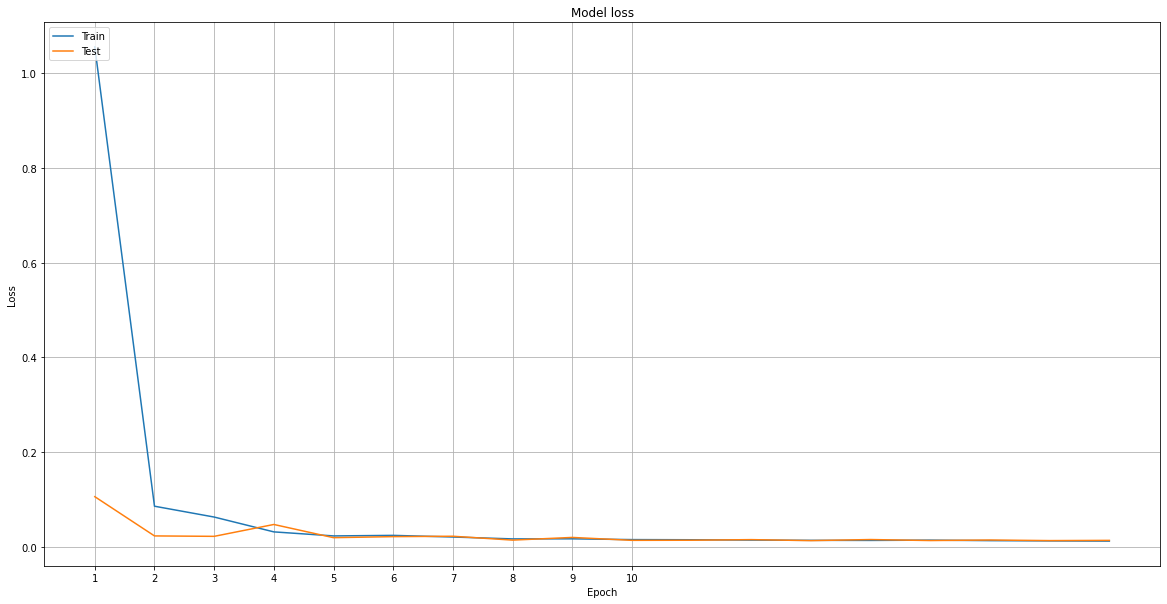

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 1.11
Mean Absolute Percentage Error (MAPE): 363.17 %
Median Absolute Percentage Error (MDAPE): 102.65 %


,MAE,MAPE,MDAPE
0,1.106304,363.170553,102.646236


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

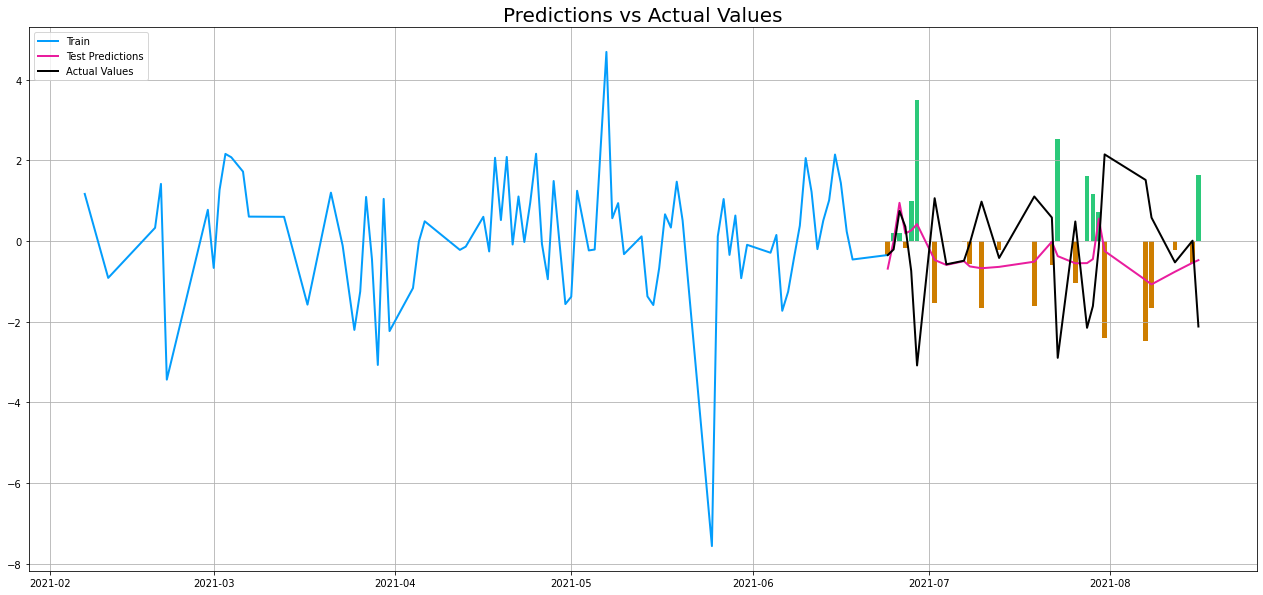

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [35]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '7D%Change', 'Volume', '2Dir', 'SD_log', 'Dir', 'High', 'Low', '2D%Change', '7Dir', 'SD', 'Open', 'Close', '3Dir', '4D%Change', '5D%Change', '5Dir', '6Dir', '6D%Change', '4Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Open(t-1),Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Daily%Change(t-1)
7,1.443841,2,3.0,2.0,5.0,39.999200,7.0,3.5,-72.727273,4.0,...,3120.00000,3120.830078,0.0,-0.559200,-3.034943,0.0,0.0,-2.064871,0.0,0.212578
9,-0.742452,4,3.0,5.0,8.0,62.499219,6.0,3.0,0.000000,5.0,...,3167.52002,3127.469971,1.0,-1.735318,-1.097033,0.0,0.0,-0.347629,0.0,-1.213558
10,0.531852,1,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,3123.02002,3104.250000,0.0,-0.319823,-2.464887,0.0,0.0,-1.831340,0.0,-0.742452
11,4.570037,2,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,3107.00000,3120.760010,0.0,-0.002245,0.210328,1.0,0.0,-1.946145,0.0,0.531852
12,1.336348,3,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,3181.98999,3263.379883,1.0,3.079387,4.567689,1.0,1.0,4.789976,1.0,4.570037


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),Daily%Change(t-1),Prediction
218,1.516196,4,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,3472.500000,0.0,-1.321117,-0.129422,0.0,1.0,2.615248,0.0,-0.274265,1.516196
219,0.582387,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,3525.149902,0.0,1.036690,0.175048,1.0,1.0,1.384812,1.0,1.516196,0.582387
223,-0.527318,4,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,3696.060059,1.0,4.848309,6.438015,1.0,1.0,6.146092,1.0,4.143704,-0.527318
226,0.010332,2,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,3580.040039,0.0,0.874614,1.111082,1.0,1.0,0.969070,1.0,0.209092,0.010332
227,-2.118468,4,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,3580.409912,0.0,-3.129012,0.885036,1.0,1.0,1.121529,0.0,0.010332,-2.118468


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(103, 100)
(32, 100)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(96, 7, 100) (96,)
(25, 7, 100) (25,)
0.6967348414194265
0.6967348414194265


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMZN_Sentiment_DailyChange_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.9176
Epoch 1: val_loss improved from inf to 0.11653, saving model to AMZN_Sentiment_DailyChange_Normalized.h5
6/6 [==============================] - 4s 347ms/step - loss: 0.9176 - val_loss: 0.1165
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0737
Epoch 2: val_loss improved from 0.11653 to 0.01364, saving model to AMZN_Sentiment_DailyChange_Normalized.h5
6/6 [==============================] - 1s 180ms/step - loss: 0.0737 - val_loss: 0.0136
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0498
Epoch 3: val_loss did not improve from 0.01364
6/6 [==============================] - 1s 176ms/step - loss: 0.0498 - val_loss: 0.0194
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0302
Epoch 4: val_loss did not improve from 0.01364
6/6 [==============================] - 1s 169ms/step - loss: 0.0302 - val_loss: 0.0175
Epoch 5/100
6/6 [==============================]

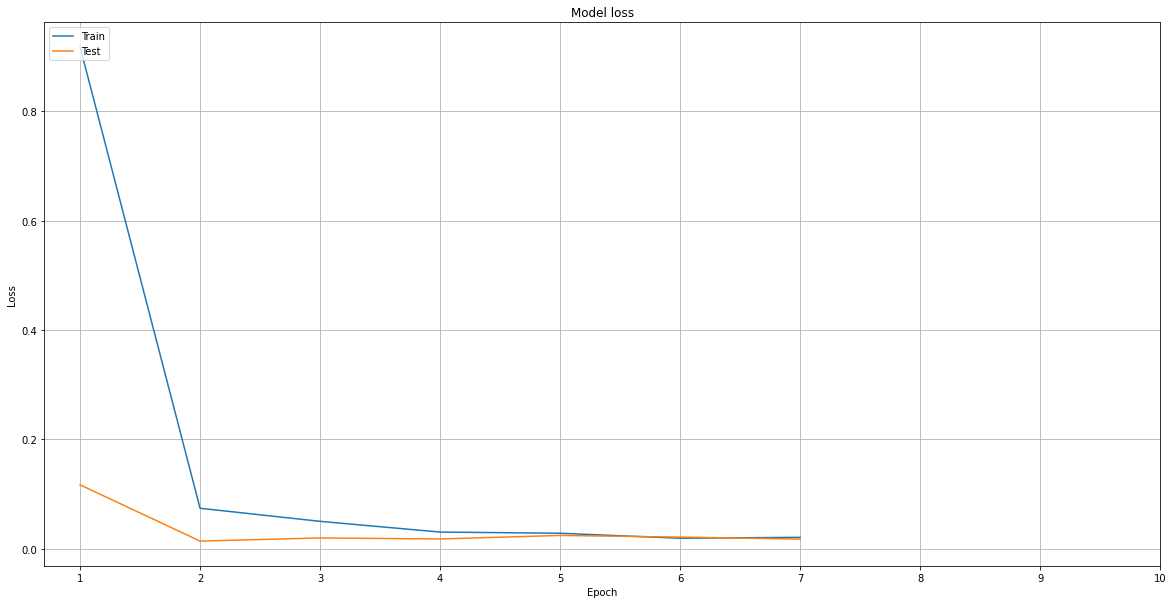

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 1.15
Mean Absolute Percentage Error (MAPE): 344.76 %
Median Absolute Percentage Error (MDAPE): 114.81 %


,MAE,MAPE,MDAPE
0,1.147167,344.755137,114.805998


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

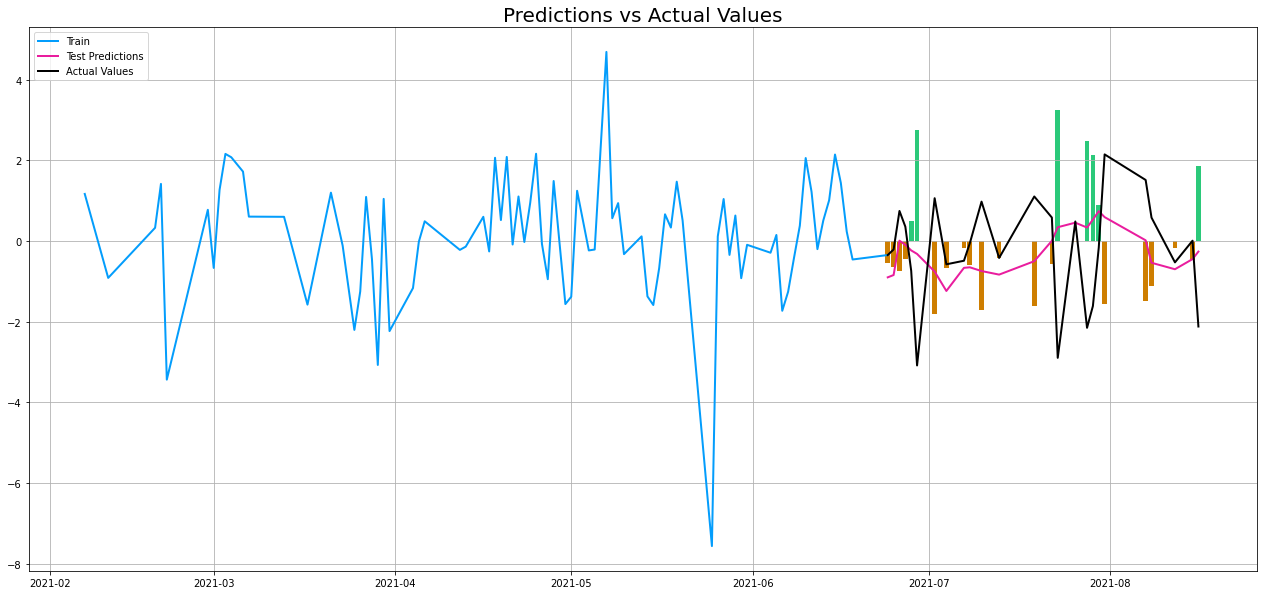

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: AMZN SD

### Without Normalization

In [45]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '7D%Change', 'Volume', '2Dir', 'SD_log', 'Daily%Change', 'Dir', 'High', 'Low', '2D%Change', '7Dir', 'Open', 'Close', '3Dir', '4D%Change', '5D%Change', '5Dir', '6Dir', '6D%Change', '4Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Open(t-1),Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),SD(t-1)
7,0.594366,2,3.0,2.0,5.0,39.999200,7.0,3.5,-72.727273,4.0,...,3120.00000,3120.830078,0.0,-0.559200,-3.034943,0.0,0.0,-2.064871,0.0,0.365688
9,0.301481,4,3.0,5.0,8.0,62.499219,6.0,3.0,0.000000,5.0,...,3167.52002,3127.469971,1.0,-1.735318,-1.097033,0.0,0.0,-0.347629,0.0,0.297757
10,0.345787,1,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,3123.02002,3104.250000,0.0,-0.319823,-2.464887,0.0,0.0,-1.831340,0.0,0.301481
11,1.053576,2,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,3107.00000,3120.760010,0.0,-0.002245,0.210328,1.0,0.0,-1.946145,0.0,0.345787
12,0.863396,3,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,3181.98999,3263.379883,1.0,3.079387,4.567689,1.0,1.0,4.789976,1.0,1.053576


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),SD(t-1),Prediction
218,0.450722,4,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,3472.500000,0.0,-1.321117,-0.129422,0.0,1.0,2.615248,0.0,0.414365,0.450722
219,0.375264,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,3525.149902,0.0,1.036690,0.175048,1.0,1.0,1.384812,1.0,0.450722,0.375264
223,0.891892,4,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,3696.060059,1.0,4.848309,6.438015,1.0,1.0,6.146092,1.0,0.626304,0.891892
226,0.470437,2,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,3580.040039,0.0,0.874614,1.111082,1.0,1.0,0.969070,1.0,0.375680,0.470437
227,0.393547,4,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,3580.409912,0.0,-3.129012,0.885036,1.0,1.0,1.121529,0.0,0.470437,0.393547


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(103, 100)
(32, 100)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(96, 7, 100) (96,)
(25, 7, 100) (25,)
0.08510669554235346
0.08510669554235346


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMZN_Sentiment_SD_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.4007
Epoch 1: val_loss improved from inf to 0.02133, saving model to AMZN_Sentiment_SD_woNormalization.h5
6/6 [==============================] - 4s 312ms/step - loss: 0.4007 - val_loss: 0.0213
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0371
Epoch 2: val_loss did not improve from 0.02133
6/6 [==============================] - 1s 140ms/step - loss: 0.0371 - val_loss: 0.0240
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0258
Epoch 3: val_loss did not improve from 0.02133
6/6 [==============================] - 1s 171ms/step - loss: 0.0258 - val_loss: 0.0292
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0164
Epoch 4: val_loss did not improve from 0.02133
6/6 [==============================] - 1s 184ms/step - loss: 0.0164 - val_loss: 0.0246
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0.0191
Epoch 5: val_loss did not improve from 0

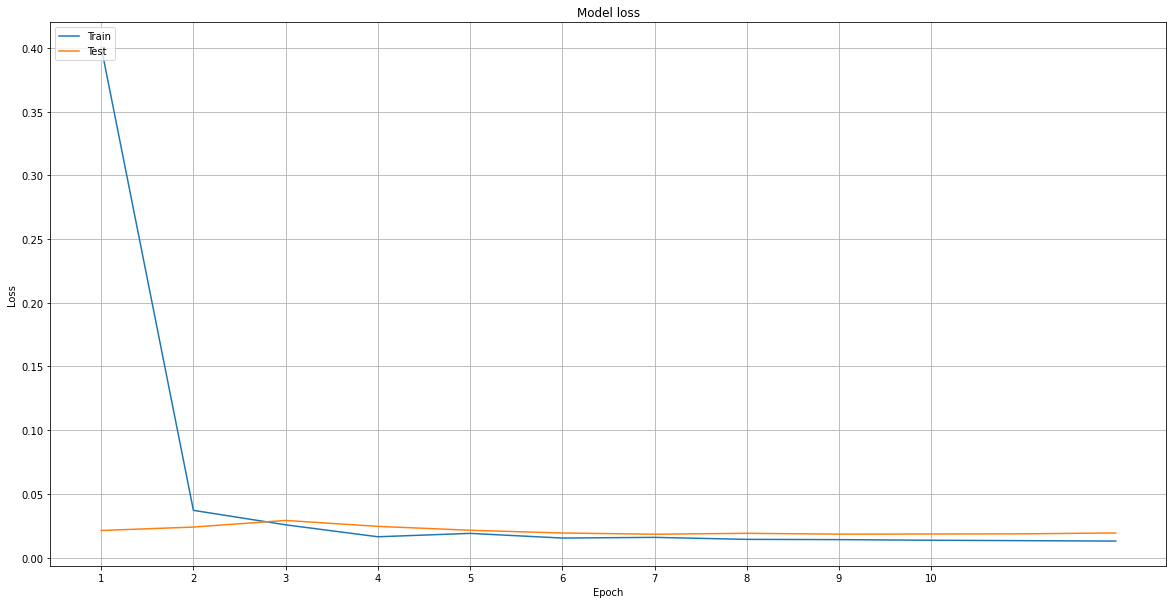

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.25
Mean Absolute Percentage Error (MAPE): 61.8 %
Median Absolute Percentage Error (MDAPE): 43.3 %


,MAE,MAPE,MDAPE
0,0.248984,61.804316,43.296969


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

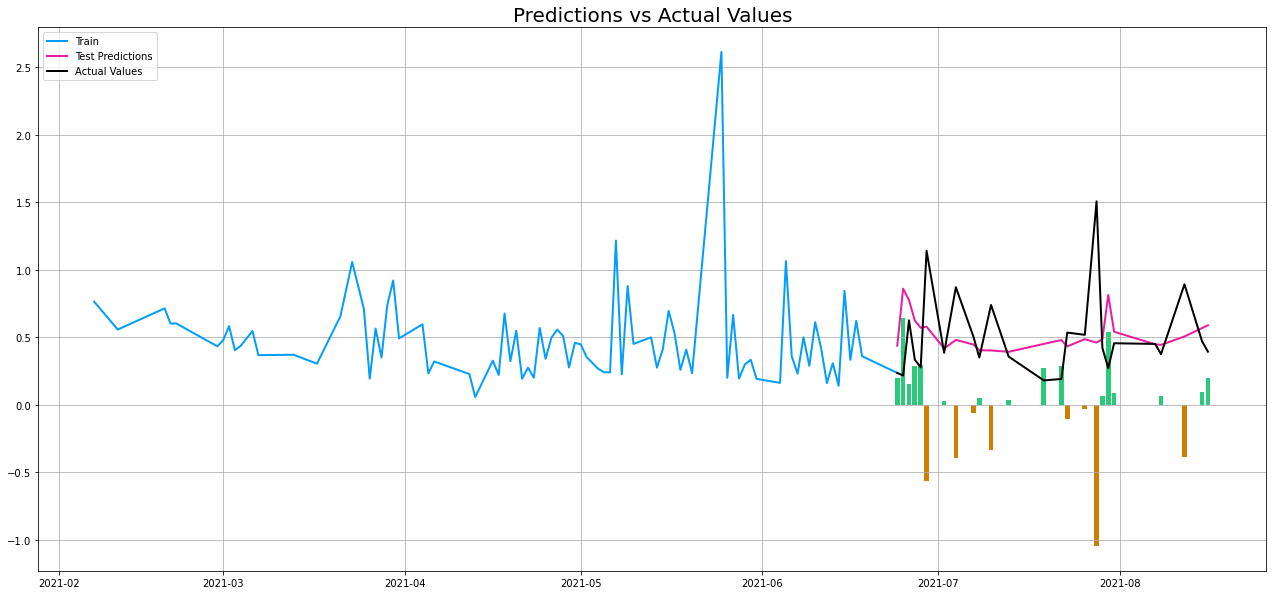

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [55]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '7D%Change', 'Volume', '2Dir', 'SD_log', 'Daily%Change', 'Dir', 'High', 'Low', '2D%Change', '7Dir', 'Open', 'Close', '3Dir', '4D%Change', '5D%Change', '5Dir', '6Dir', '6D%Change', '4Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Open(t-1),Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),SD(t-1)
7,0.594366,2,3.0,2.0,5.0,39.999200,7.0,3.5,-72.727273,4.0,...,3120.00000,3120.830078,0.0,-0.559200,-3.034943,0.0,0.0,-2.064871,0.0,0.365688
9,0.301481,4,3.0,5.0,8.0,62.499219,6.0,3.0,0.000000,5.0,...,3167.52002,3127.469971,1.0,-1.735318,-1.097033,0.0,0.0,-0.347629,0.0,0.297757
10,0.345787,1,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,3123.02002,3104.250000,0.0,-0.319823,-2.464887,0.0,0.0,-1.831340,0.0,0.301481
11,1.053576,2,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,3107.00000,3120.760010,0.0,-0.002245,0.210328,1.0,0.0,-1.946145,0.0,0.345787
12,0.863396,3,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,3181.98999,3263.379883,1.0,3.079387,4.567689,1.0,1.0,4.789976,1.0,1.053576


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),3Dir(t-1),4D%Change(t-1),5D%Change(t-1),5Dir(t-1),6Dir(t-1),6D%Change(t-1),4Dir(t-1),SD(t-1),Prediction
218,0.450722,4,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,3472.500000,0.0,-1.321117,-0.129422,0.0,1.0,2.615248,0.0,0.414365,0.450722
219,0.375264,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,3525.149902,0.0,1.036690,0.175048,1.0,1.0,1.384812,1.0,0.450722,0.375264
223,0.891892,4,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,3696.060059,1.0,4.848309,6.438015,1.0,1.0,6.146092,1.0,0.626304,0.891892
226,0.470437,2,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,3580.040039,0.0,0.874614,1.111082,1.0,1.0,0.969070,1.0,0.375680,0.470437
227,0.393547,4,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,3580.409912,0.0,-3.129012,0.885036,1.0,1.0,1.121529,0.0,0.470437,0.393547


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(103, 100)
(32, 100)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(96, 7, 100) (96,)
(25, 7, 100) (25,)
0.08510669554235346
0.08510669554235346


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMZN_Sentiment_SD_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.6824
Epoch 1: val_loss improved from inf to 0.03123, saving model to AMZN_Sentiment_SD_Normalized.h5
6/6 [==============================] - 4s 378ms/step - loss: 1.6824 - val_loss: 0.0312
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0692
Epoch 2: val_loss did not improve from 0.03123
6/6 [==============================] - 1s 183ms/step - loss: 0.0692 - val_loss: 0.0380
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0431
Epoch 3: val_loss did not improve from 0.03123
6/6 [==============================] - 1s 212ms/step - loss: 0.0431 - val_loss: 0.0605
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0270
Epoch 4: val_loss did not improve from 0.03123
6/6 [==============================] - 1s 192ms/step - loss: 0.0270 - val_loss: 0.0430
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0.0283
Epoch 5: val_loss did not improve from 0.0312

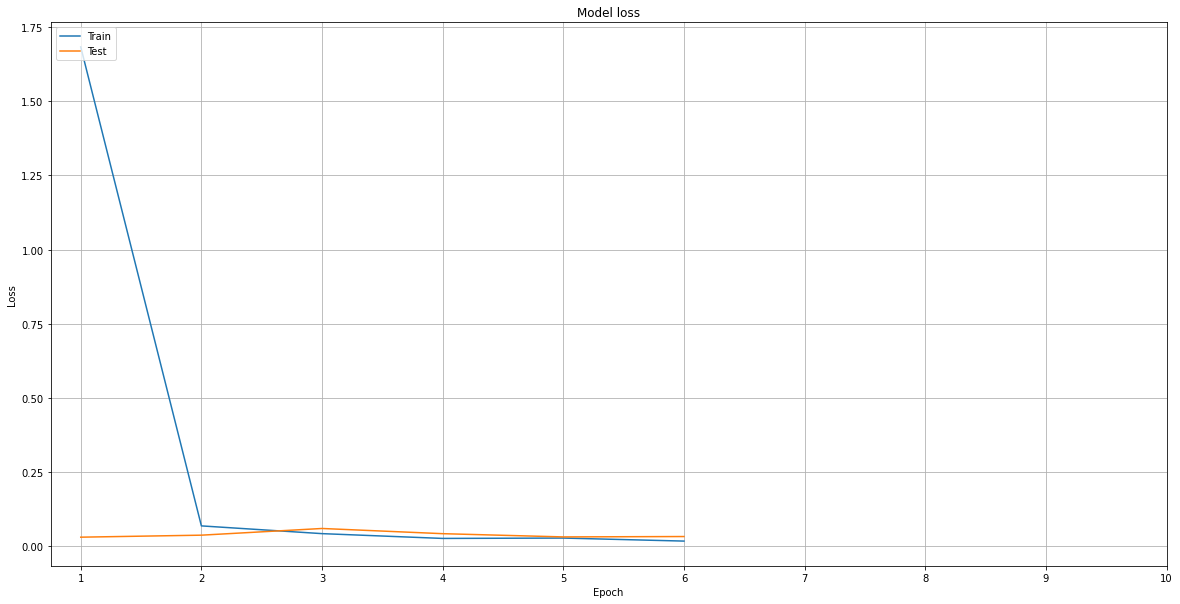

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.33
Mean Absolute Percentage Error (MAPE): 63.86 %
Median Absolute Percentage Error (MDAPE): 73.64 %


,MAE,MAPE,MDAPE
0,0.334942,63.855546,73.639627


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

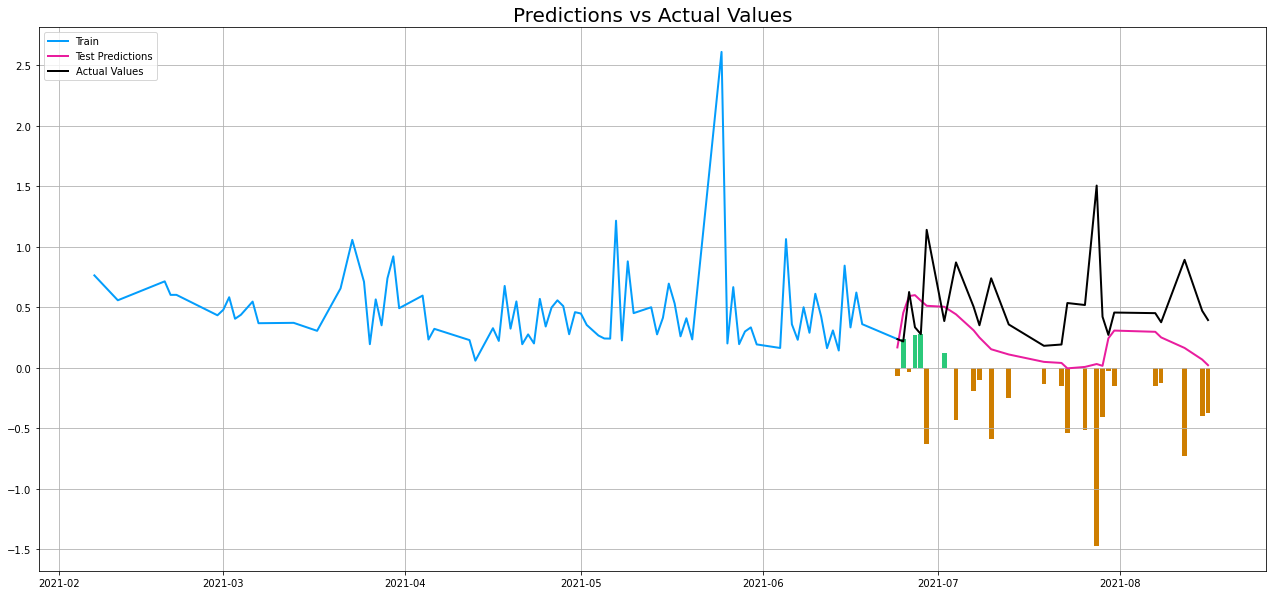

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()